[1 - Prepare the data](#1---Prepare-the-data-)<br>
&ensp;&ensp;[1.1 - Generate annotation files](#1.1---Generate-annotation-files-(see-here))<br>
&ensp;&ensp;[1.2 - Create a subset for fast prototyping](#1.2---Create-a-subset-for-fast-prototyping)<br>
&ensp;&ensp;[1.3 - Compute features and write them to TFRecord](#1.3---Compute-features-and-write-them-to-TFRecord-files)<br>
&ensp;&ensp;[1.4 - Check some TFRecord](#1.4---Check-some-TFRecord)<br>
&ensp;&ensp;[1.5 - Check some other TFRecord](#1.5---Check-some-other-TFRecord)<br>
[2 - Training](#2---Training)<br>
&ensp;&ensp;[2.1 - Generate a train/valid split to monitor the performance on unseen data](#2.1---Generate-a-train/valid-split-to-monitor-the-performance-on-unseen-data)<br>
&ensp;&ensp;[2.2 - Count the number of batches in the train and valid sets](#2.2---Count-the-number-of-batches-in-the-train-and-valid-sets)<br>
&ensp;&ensp;[2.3 - Write feature extraction and training config files](#2.3---Write-feature-extraction-and-training-config-files)<br>
&ensp;&ensp;[2.4 - Train](#2.4---Train)


# 1 - Prepare the data

Original challenge data, as found at https://www.kaggle.com/c/freesound-audio-tagging-2019/data.
Audio data is resampled to 22050 Hz for faster prototyping.

In [1]:
! tree /home/jul/data/freesound-audio-tagging-2019/ -I 'subset*|annotations*|*wav|test'

/home/jul/data/freesound-audio-tagging-2019/
├── custom_subsets
├── sample_submission.csv
└── train
    ├── train_curated
    │   ├── audio
    │   ├── audio_22050hz
    │   └── train_curated.csv
    └── train_noisy
        ├── audio
        ├── audio_22050hz
        └── train_noisy.csv

8 directories, 3 files


## 1.1 - Generate annotation files (see [here](https://github.com/phaunos/phaunos_ml/blob/7fe9a4d07821a3ae0a5cdc353dc27fd332c5132c/phaunos_ml/utils/annotation_utils.py))

**Note**: Using annotation files here might be overkill because the annotations are "per file", but this is a generic way to handle any kind of annotations, including those applied to regions of a file (i.e. with start/end times).

In [2]:
from challenge_utils.dcase2019_task2_utils import get_class_list, generate_ann_files

In [3]:
class_list = get_class_list('/home/jul/data/freesound-audio-tagging-2019/sample_submission.csv')

In [4]:
print(class_list)

['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar', 'Bathtub_(filling_or_washing)', 'Bicycle_bell', 'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Cheering', 'Chewing_and_mastication', 'Child_speech_and_kid_speaking', 'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping', 'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd', 'Cupboard_open_or_close', 'Cutlery_and_silverware', 'Dishes_and_pots_and_pans', 'Drawer_open_or_close', 'Drip', 'Electric_guitar', 'Fart', 'Female_singing', 'Female_speech_and_woman_speaking', 'Fill_(with_liquid)', 'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong', 'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock', 'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone', 'Mechanical_fan', 'Meow', 'Microwave_oven', 'Motorcycle', 'Printer', 'Purr', 'Race_car_and_auto_racing', 'Raindrop', 'Run', 'Scissors', 'Screaming', 'Shatter', 

In [5]:
generate_ann_files('/home/jul/data/freesound-audio-tagging-2019/train', class_list)

Annotation file contains all annotations of a given audio file. Each line represent a region and one or more label ids:
    start_time,end_time(-1 if the annotation is for the whole audio file, as in our case),label_ids (joined by '#'):

In [6]:
!head -5 /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/* | head -8

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/00097e21.ann <==
0.000,-1.000,7

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/000b6cfb.ann <==
0.000,-1.000,51

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/00116cd2.ann <==
0.000,-1.000,37#47
head: error writing 'standard output': Broken pipe


## 1.2 - Create a subset for fast prototyping

In [7]:
import numpy as np
from phaunos_ml.utils.dataset_utils import create_subset, dataset_stat_per_file

In [8]:
# Pick 10 classes randomly
subset_label_set = set(np.random.choice(range(len(class_list)), 10, replace=False))
print(subset_label_set)

{3, 70, 39, 42, 46, 15, 50, 25, 27, 62}


In [9]:
# Create a data subset with all files annotated with at least one of these classes.
subset_filename = create_subset(
    '/home/jul/data/freesound-audio-tagging-2019/train/',
    ['train_noisy', 'train_curated'],
    '/home/jul/data/freesound-audio-tagging-2019/custom_subsets',
    audio_dirname='audio_22050hz',
    label_set=subset_label_set)
print(subset_filename)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1563962862/subset_1563962862.csv


This basically create a file with a unique name (*subset_&lt;timestamp&gt;.csv*) containing a list of files with their annotations (intersecting with label_set):

In [10]:
!head -10 "$subset_filename"

#class subset: 3,15,25,27,39,42,46,50,62,70
train_noisy/audio_22050hz/39e85c95.wav,50
train_noisy/audio_22050hz/36eb7e34.wav,46
train_noisy/audio_22050hz/b9ab08ed.wav,3
train_noisy/audio_22050hz/4e7fd59b.wav,50
train_noisy/audio_22050hz/a0f907cb.wav,3
train_noisy/audio_22050hz/68a1ab1c.wav,50
train_noisy/audio_22050hz/54260b02.wav,15
train_noisy/audio_22050hz/150ea5da.wav,50
train_noisy/audio_22050hz/2f2a5f9b.wav,42


In [11]:
# Show dataset stats
# Note: The total number of instances might be higher than the number of audio files because a file might have multiple labels
d_num, d_dur = dataset_stat_per_file('/home/jul/data/freesound-audio-tagging-2019/train/', subset_filename)
print("Class index, number of files, total duration (in s)") 
for k, v in sorted(d_num.items()): 
    print(f' {k:<10},{v:<10},{d_dur[k]:<10.3f}')

3652it [04:20, 14.03it/s]

Class index, number of files, total duration (in s)
 3         ,375       ,5148.906  
 15        ,375       ,4627.295  
 25        ,375       ,4624.084  
 27        ,375       ,4847.680  
 39        ,375       ,4855.031  
 42        ,375       ,5156.028  
 46        ,375       ,4678.907  
 50        ,375       ,4973.983  
 62        ,375       ,4480.297  
 70        ,375       ,5432.625  


## 1.3 - Compute features and write them to [TFRecord](https://www.tensorflow.org/tutorials/load_data/tf_records) files

In [12]:
import os
from phaunos_ml.utils.feature_utils import MelSpecExtractor
from phaunos_ml.utils.dataset_utils import dataset2tfrecords
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [13]:
# Log-mel spectrogram in 2s examples
feature_extractor = MelSpecExtractor(n_fft=512,
                                     hop_length=128,
                                     n_mels = 128,
                                     example_duration=2,
                                     example_hop_duration=1)

In [14]:
# Process our subset. TFRecords are written in 
tfrecord_path = os.path.join(os.path.dirname(subset_filename), 'features')
dataset2tfrecords('/home/jul/data/freesound-audio-tagging-2019/train/',
                 subset_filename,
                 tfrecord_path,
                 feature_extractor,
                 audio_dirname='audio_22050hz')

100%|██████████| 3653/3653 [11:16<00:00,  5.40it/s]


## 1.4 - Check some TFRecord

In [15]:
import random
import tensorflow as tf
from phaunos_ml.utils import tf_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
subset_dir = os.path.dirname(subset_filename)
sometfrecord_path = os.path.join(subset_dir, 'features/train_curated/audio_22050hz/')

In [17]:
sometfrecord = os.path.join(
    sometfrecord_path,
    random.sample(os.listdir(sometfrecord_path), 1)[0]
)

In [18]:
print(sometfrecord)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1563962862/features/train_curated/audio_22050hz/4196347d.tf


In [19]:
someexamples = tf_utils.tfrecord2example(sometfrecord, feature_extractor)
print(someexamples)

W0724 12:23:21.349239 139930500319040 deprecation.py:323] From /home/jul/.miniconda3/envs/datest/lib/python3.6/site-packages/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0724 12:23:21.357308 139930500319040 deprecation_wrapper.py:119] From /home/jul/.miniconda3/envs/datest/lib/python3.6/site-packages/phaunos_ml/utils/tf_utils.py:51: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[{'data': array([[ -1.0614069,  -1.6800154,  -2.8618386, ...,  -0.9625941,
         -1.5767542,  -1.2625184],
       [ -1.3750894,  -1.9936978,  -3.175521 , ...,  -1.2762766,
         -1.8904366,  -1.5762007],
       [ -5.4769697,  -1.6762023,  -3.5450284, ...,  -1.1477689,
         -2.2053332,  -0.5452884],
       ...,
       [-10.180502 ,  -9.591197 ,  -9.86761  , ..., -10.101692 ,
        -10.690926 ,  -9.759046 ],
       [ -9.195526 ,  -9.695203 , -10.92997  , ..., -10.3402605,
        -11.486475 , -10.541734 ],
       [-10.845221 , -11.046109 , -12.339159 , ..., -10.877119 ,
        -11.378699 , -10.605519 ]], dtype=float32), 'filename': b'train_curated/audio_22050hz/4196347d.tf', 'labels': b'50', 'times': array([0.      , 1.996916], dtype=float32)}, {'data': array([[ -0.8406519 ,  -1.0145173 ,  -0.91685915, ...,  -0.6743772 ,
         -0.60742736,  -0.61965656],
       [ -1.1543343 ,  -1.3281997 ,  -1.2305415 , ...,  -0.9880595 ,
         -0.9211098 ,  -0.93333894],
       [ -0.6

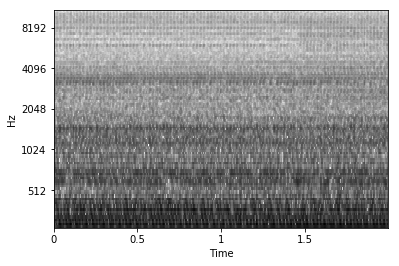

In [20]:
# First example in the TFRecord
feature_extractor.plot(someexamples[0]['data'])

## 1.5 - Check some other TFRecord

In [21]:
someothertfrecord = os.path.join(
    sometfrecord_path,
    random.sample(os.listdir(sometfrecord_path), 1)[0]
)
print(someothertfrecord)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1563962862/features/train_curated/audio_22050hz/bc5fd19c.tf


### As examples

In [22]:
otherexamples = tf_utils.tfrecord2example(someothertfrecord, feature_extractor)

In [23]:
print(otherexamples)

[{'data': array([[-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.420681],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.420681],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.420681],
       ...,
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.420681],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.420681],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.420681]], dtype=float32), 'filename': b'train_curated/audio_22050hz/bc5fd19c.tf', 'labels': b'39', 'times': array([0.  , 0.62], dtype=float32)}]


### As input (features + one-hot encoded labels) to the model

In [24]:
subset_class_list = sorted(list(subset_label_set)) # labels are one-hot encoded according to this list

In [25]:
print(subset_class_list)

[3, 15, 25, 27, 39, 42, 46, 50, 62, 70]


In [26]:
example_as_input = tf_utils.tfrecord2data(someothertfrecord, feature_extractor, subset_class_list)

W0724 12:23:21.956464 139930500319040 deprecation.py:323] From /home/jul/.miniconda3/envs/datest/lib/python3.6/site-packages/phaunos_ml/utils/tf_utils.py:143: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
# model_input is a list of tuple (<features>, <one-hot encoded labels>)
print(example_as_input)

[(array([[[-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.420681],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.420681],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.420681],
        ...,
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.420681],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.420681],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.420681]]], dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32))]


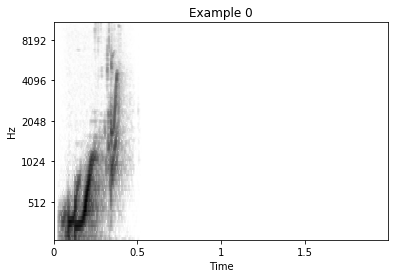

In [28]:
# Plot features for random examples from the selected file
ind = sorted(random.sample(range(len(example_as_input)),min(len(example_as_input), 3)))
for i in ind:    
    plt.figure()
    feature_extractor.plot(example_as_input[i][0][0])
    plt.title(f'Example {i}')

# 2 - Training

## 2.1 - Generate a train/valid split to monitor the performance on unseen data

In [29]:
from phaunos_ml.utils.dataset_utils import split_dataset

In [30]:
# This generates 2 files,
# /subset/path/subset_name.train.csv containing 80% of the data (training dataset)
# /subset/path/subset_name.test.csv containing 20% of the data (validation dataset, to select the model)
split_dataset(subset_filename, test_size=0.2)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1563962862/subset_1563962862.train.csv written
/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1563962862/subset_1563962862.test.csv written


## 2.2 - Count the number of batches in the train and valid sets

In [31]:
from phaunos_ml.utils.dataset_utils import dataset_stat_per_example
BATCH_SIZE = 32

In [32]:
# training set
n_train_batches, n_train_examples_per_class = dataset_stat_per_example(
    subset_filename.replace('.csv', '.train.csv'),
    os.path.join(os.path.dirname(subset_filename), 'features'),
    feature_extractor.feature_shape,
    subset_class_list,
    batch_size=BATCH_SIZE)
print(f'Num training batches: {n_train_batches} (i.e. {n_train_batches * BATCH_SIZE} examples)')
for c, n in zip(subset_class_list, n_train_examples_per_class):
    print(f'Class {c:2}: {n} examples')
# Note: the number of examples n_train_batches * BATCH_SIZE is <= to sum(n_train_examples_per_class)
# because data is multilabel
print(f'{n_train_batches * BATCH_SIZE} <= {np.sum(n_train_examples_per_class)}')

Num training batches: 1138 (i.e. 36416 examples)
Class  3: 3983 examples
Class 15: 3483 examples
Class 25: 3484 examples
Class 27: 3673 examples
Class 39: 3730 examples
Class 42: 4015 examples
Class 46: 3544 examples
Class 50: 3871 examples
Class 62: 3418 examples
Class 70: 4303 examples
36416 <= 37504


In [33]:
# valid set
n_valid_batches, n_valid_examples_per_class = dataset_stat_per_example(
    subset_filename.replace('.csv', '.test.csv'),
    os.path.join(os.path.dirname(subset_filename), 'features'),
    feature_extractor.feature_shape,
    subset_class_list,
    batch_size=BATCH_SIZE)
print(f'Num valid batches: {n_valid_batches} (i.e. {n_valid_batches * BATCH_SIZE} examples)')
for c, n in zip(subset_class_list, n_valid_examples_per_class):
    print(f'Class {c:2}: {n} examples')
# Note: the number of examples n_valid_batches * BATCH_SIZE is <= to sum(n_valid_examples_per_class)
# because data is multilabel
print(f'{n_valid_batches * BATCH_SIZE} <= {np.sum(n_valid_examples_per_class)}')

Num valid batches: 334 (i.e. 10688 examples)
Class  3: 1117 examples
Class 15: 1115 examples
Class 25: 1117 examples
Class 27: 1118 examples
Class 39: 1085 examples
Class 42: 1096 examples
Class 46: 1114 examples
Class 50: 1073 examples
Class 62: 1034 examples
Class 70: 1085 examples
10688 <= 10954


## 2.3 - Write feature extraction and training config files

In [34]:
import json

EPOCHS = 10

In [35]:
# Write feature extractor's config file
feature_extractor.config2file(os.path.join(subset_dir, 'features', 'featex_config.json'))

In [36]:
# Write training config file

training_dir = os.path.join(subset_dir, 'training')

training_config = {}
training_config['feature_path'] = os.path.join(subset_dir, 'features')
training_config['train_set_file'] = subset_filename.replace('.csv', '.train.csv')
training_config['n_train_batches'] = n_train_batches
training_config['batch_size'] = BATCH_SIZE
training_config['multilabel'] = True
training_config['epochs'] = EPOCHS
training_config['out_dir'] = training_dir
training_config['valid_set_file'] = subset_filename.replace('.csv', '.test.csv')
training_config['n_valid_batches'] = n_valid_batches

training_config_path = os.path.join(training_dir, 'training_config.json')
os.makedirs(training_dir)

with open(training_config_path, 'w') as training_config_file:
    json.dump(training_config, training_config_file)

## 2.4 - Train

In [37]:
from phaunos_ml import train

In [38]:
train.process(training_config_path)

W0724 12:24:03.248075 139930500319040 deprecation.py:506] From /home/jul/.miniconda3/envs/datest/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mels (InputLayer)            [(32, 1, 128, 344)]       0         
_________________________________________________________________
l1_conv (Conv2D)             (32, 32, 126, 342)        288       
_________________________________________________________________
l1_bn (BatchNormalization)   (32, 32, 126, 342)        96        
_________________________________________________________________
l1 (Activation)              (32, 32, 126, 342)        0         
_________________________________________________________________
l1_mp (MaxPooling2D)         (32, 32, 62, 170)         0         
_________________________________________________________________
l2_conv (Conv2D)             (32, 32, 58, 166)         25600     
_________________________________________________________________
l2_bn (BatchNormalization)   (32, 32, 58, 166)         96    